# Import libraries

In [1]:
import os
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import googlemaps
import matplotlib.pyplot as plt
import matplotlib as mpl

# Collect Data

In [2]:
# origin = (42.443962,-76.501884)
origin = ox.geocode('311 E Green St, Ithaca, NY 14850')

radius=6000

known_trails = {'Black Diamond Trail','Lick Brook Trail','Bear Trail','East Trail','Dewitt Exercise Trail','Lake Treman Trail','Gorge Trail','Finger Lakes Trail','Rachel Carson Trail','Cayuga Waterfront Trail','Ithaca Waterfront Trail','Northeast Ithaca Recreation Way','East Ithaca Recreation Way','South Hill Recreation Way','Cascadilla Gorge Trail','Rim Trail','Cayuga Trail','Boothroyd Woods Trail'}
# known_trails=None

In [3]:
import sys
sys.path.append('./src/')

from collect_data import *
G, edge_data = collect_data(origin,radius,known_trails)

Getting park edge data
Getting water edge data


In [4]:
import pickle
obj = {}
obj['graph'] = G
obj['edge_data']  = edge_data

pickle.dump( obj, open( "./Generating-Ideal-Routes.p", "wb" ) )

## Load

In [5]:
import pickle
obj = pickle.load( open( "./Generating-Ideal-Routes.p", "rb" ) )

G = obj['graph']
edge_data = obj['edge_data']

In [107]:
'''
User_preferences:
    impedance
    water_dist_impedance
    nature_dist_impedance
    is_not_trail_penalty
'''
# User_preferences = (0,1,0,0)
User_preferences = (0,1,0,0)

In [108]:
import sys
sys.path.append('./src/')
from dijkstra_wrapper import *

target_distance = 15500
shortest_path = Dijkstra(origin,target_distance,G,edge_data,User_preferences)

# Plot Data

In [8]:
from reorder_polygons import *
tags = {'natural':'water'}
pois_water = ox.pois_from_point(origin,tags,dist=radius)
tags = {'leisure':'park'}
park_pois = ox.pois_from_point(origin,tags,dist=radius)

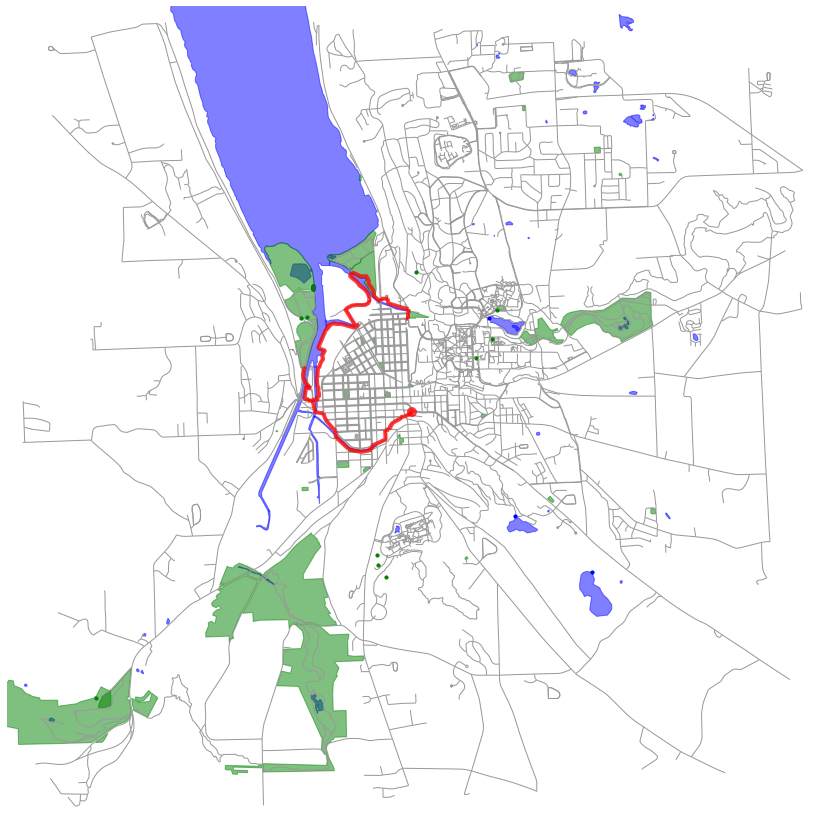

In [109]:
# fig, ax = ox.plot_graph(G, fig_height=14, fig_width=14,edge_color=edge_colors,node_size=0, show=False, close=False)
fig, ax = ox.plot_graph_route(G, route=shortest_path, node_size=0, fig_height=15, fig_width=15, show=False, close=False)

failed_add = []
        
for lake in pois_water['geometry']:
    try:
        lake_multipolygon = lake
        
        if isinstance(lake_multipolygon, Polygon):
            add_polygon(ax,[lake_multipolygon])
        elif isinstance(lake_multipolygon,Point):
            point = list(lake_multipolygon.coords)[0]
            ax.scatter(point[0],point[1],c='blue',alpha=1,s=10,zorder=20)
        elif isinstance(lake_multipolygon,MultiPolygon):
            add_polygon(ax,OrderMultiPolygon(lake_multipolygon))
            
    except:
        pass
        
for park in park_pois['geometry']:
    try:
        park_multipolygon = park
        if isinstance(park_multipolygon, Polygon):
            add_polygon(ax,[park_multipolygon],'green')
        elif isinstance(park_multipolygon,MultiPolygon):
            add_polygon(ax,OrderMultiPolygon(park_multipolygon),'green')
        elif isinstance(park_multipolygon,Point):
            point = list(park_multipolygon.coords)[0]
            ax.scatter(point[0],point[1],c='green',alpha=1,s=10,zorder=20)
            
    except:
        pass

plt.show()

# Visualize Impedance Optimization

In [110]:
# shortest_path
# map(edge_data)
hash_ = {}
for edge in edge_data:
    hash_[(edge[0],edge[1])] = [edge[2],edge[3],edge[4],edge[5],edge[6]]
    hash_[(edge[1],edge[0])] = [edge[2],edge[3],edge[4],edge[5],edge[6]]

In [111]:
shortest_path_data = []
for i in range(len(shortest_path)-1):
    val = hash_[(shortest_path[i],shortest_path[i+1])]
    shortest_path_data.append(val[:])

Text(0, 0.5, 'Impedance')

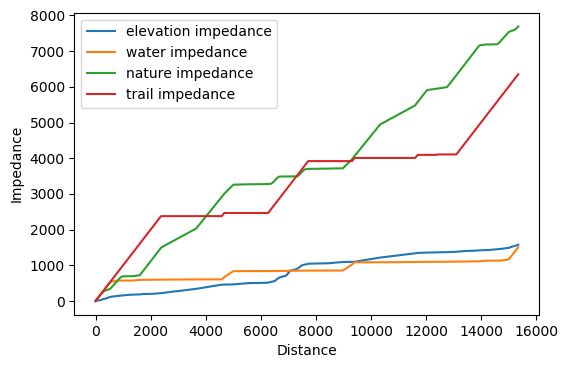

In [112]:
integrated_path_data = [np.array([0,0,0,0,0])]
for i in range(len(shortest_path)-2):
    integrated_path_data.append(integrated_path_data[-1]+np.array(shortest_path_data[i]))

integrated_path_data = np.array(integrated_path_data)
plt.figure(dpi=100)
plt.plot(integrated_path_data[:,0],integrated_path_data[:,1],label='elevation impedance')
plt.plot(integrated_path_data[:,0],integrated_path_data[:,2],label='water impedance')
plt.plot(integrated_path_data[:,0],integrated_path_data[:,3],label='nature impedance')
plt.plot(integrated_path_data[:,0],integrated_path_data[:,4],label='trail impedance')
plt.legend(loc="upper left")
plt.xlabel('Distance')
plt.ylabel('Impedance')

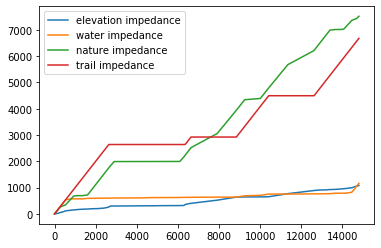

In [61]:
integrated_path_data = [np.array([0,0,0,0,0])]
for i in range(len(shortest_path)-2):
    integrated_path_data.append(integrated_path_data[-1]+np.array(shortest_path_data[i]))

integrated_path_data = np.array(integrated_path_data)
plt.plot(integrated_path_data[:,0],integrated_path_data[:,1],label='elevation impedance')
plt.plot(integrated_path_data[:,0],integrated_path_data[:,2],label='water impedance')
plt.plot(integrated_path_data[:,0],integrated_path_data[:,3],label='nature impedance')
plt.plot(integrated_path_data[:,0],integrated_path_data[:,4],label='trail impedance')
plt.legend(loc="upper left")

## To Do 

- Wrap code as callable python functions
- Get top k routes from heap
- Histogram edge data and rescale
- Speed up get_min_dist
- ML for user preferences
- Get site online